In [1]:
##Author: Sikander Hayat
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string

#from scanpy.plotting._tools import plot_scatter
sc.set_figure_params(vector_friendly=False, fontsize=18)

import pandas as pd
import numpy as np
import anndata
from scipy.io import mmwrite
import matplotlib.pyplot as plt
from collections import Counter
from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.system("mkdir "+ dirpath)

In [3]:
home      = "/Users/noamibrahimhayat/Documents/Aachen/projects/konrad_CXCL4/"
datahome  = home+ "data/"
resulthome= home+ "results/"

In [4]:
makedirs(home)
makedirs(datahome)
makedirs(resulthome)

In [5]:
filename2   = "scvi_output.h5ad"
cluster_file= filename2[:-5]+'_clustered.h5ad'

In [6]:
## read adata
adata = sc.read_h5ad(resulthome+filename2)

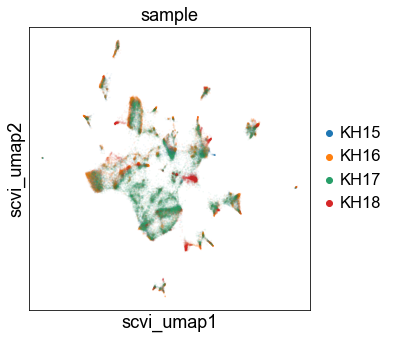

In [7]:
# check out how it looks by sample
plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='scvi_umap', color='sample', ax=plt.gca(), size=10, alpha=0.05)

In [9]:
# add treatment status
sham_ko    = set(["KH15"])
iri_ko     = set(['KH16'])
sham_wt    = set(['KH17'])
iri_wt     = set(['KH18'])

def get_treatment(s):
    if s in sham_ko:
        return 'Cxcl4_KO_Sham'
    elif s in iri_ko:
        return 'CXCL4_KO_IRI'
    elif s in sham_wt:
        return 'WT_Sham' 
    elif s in iri_wt:
        return 'WT_IRI' 
    else:
        raise ValueError(f'sample {s} not included')

adata.obs['condition'] = adata.obs['sample'].apply(get_treatment).astype('category')

In [10]:
res = 0.5

# make a copy to store log-normalized matrix for marker gene selection
tmp_copy_adata = adata.copy()

# calculate neighborhood using scvi representation and euclidean distance
sc.pp.neighbors(tmp_copy_adata, n_neighbors=50, use_rep='X_scvi', metric='euclidean')

## cluster using leiden
sc.tl.leiden(tmp_copy_adata, resolution=res, key_added='leiden' + str(res))

## normalize
sc.pp.normalize_total(tmp_copy_adata)

## log
sc.pp.log1p(tmp_copy_adata)

## find markers using Scanpy's Wilcoxon implementation
sc.tl.rank_genes_groups(tmp_copy_adata,
                        groupby='leiden' + str(res),
                        key_added='rank_genes_groups' + str(res),
                        method='wilcoxon',
                        use_raw=False)

In [14]:
tmp_copy_adata

AnnData object with n_obs × n_vars = 66369 × 24438
    obs: 'n_gene', 'n_umi', 'sample', 'mito_fraction', 'batch', 'scrublet', 'n_genes', 'scvi_batch', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'condition', 'leiden0.5'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'sample_colors', 'neighbors', 'leiden', 'log1p', 'rank_genes_groups0.5'
    obsm: 'X_scvi', 'X_scvi_umap'
    obsp: 'distances', 'connectivities'

In [17]:
adata

AnnData object with n_obs × n_vars = 66369 × 24438
    obs: 'n_gene', 'n_umi', 'sample', 'mito_fraction', 'batch', 'scrublet', 'n_genes', 'scvi_batch', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'condition'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'sample_colors', 'rank_genes_groups0.5', 'neighbors'
    obsm: 'X_scvi', 'X_scvi_umap'

In [18]:
# copy back marker gene information to adata
try:
    adata.obs['leiden' + str(res)] = tmp_copy_adata.obs['leiden' + str(res)]
except:
    print('Failed to copy clustering data')
    
try:
    adata.uns['neighbors'] = tmp_copy_adata.uns['neighbors']
except:
    print('Failed to copy neighbors data')
    
try:
    adata.uns['rank_genes_groups' + str(res)] = tmp_copy_adata.uns['rank_genes_groups' + str(res)]
except:
    print('Failed to copy rank_genes_groups data')

if '__is_in_cluster__' in adata.obs.keys():
    del adata.obs['__is_in_cluster__']

Text(0.5, 1.0, 'cxcl4 case/control leiden0.5')

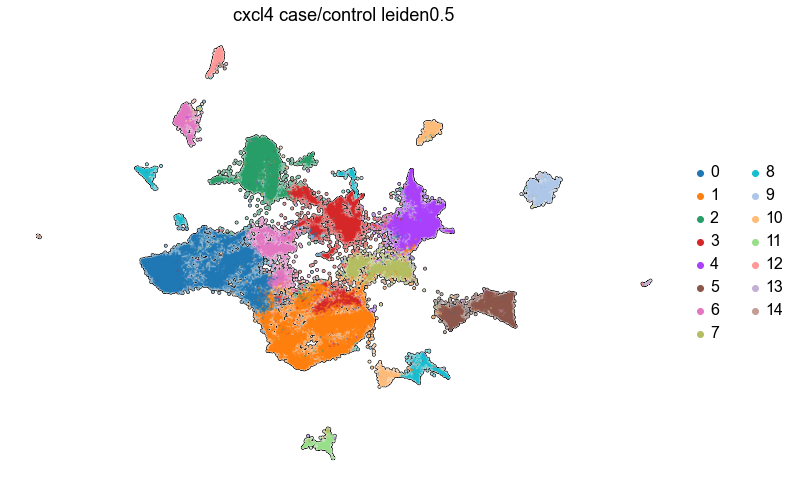

In [23]:
plt.figure(figsize=(12, 8))
sc.pl.embedding(adata, add_outline=True, basis='scvi_umap', color='leiden' + str(res),\
                ax=plt.gca(), alpha=0.5, size=20, legend_fontsize=16,legend_fontoutline=8,\
                frameon=False, show=False)
plt.title('cxcl4-study case/control leiden' + str(res))

In [24]:
# Check to see if its counts
adata[:,'Neat1'].X.todense()

matrix([[ 3.],
        [10.],
        [ 0.],
        ...,
        [ 3.],
        [ 5.],
        [ 2.]], dtype=float32)

In [31]:
#  Add cluster names

cluster_names = {'0'  :'0: DCT',
'1'  :'1: PT',
'2'  :'2: TAL',
'3'  :'3: Endo',
'4'  :'4: Fibro',
'5'  :'5: IC',
'6'  :'6: PC',
'7'  :'7: Leukocytes',
'8'  :'8: DTL',
'9'  :'9: Podo',
'10' :'10: Injured PT',
'11' :'11: VSMC',
'12'  :'9: PC/DME',
'13' :'10: Adipocytes',
'14' :'11: FB2'        }

## uncomment to add cluster names
#adata.obs['leiden' + str(res)] = adata.obs['leiden' + str(res)].apply(lambda s: cluster_names[s])

In [25]:
#adata.write(resulthome + cluster_file)

Number of clusters 15
0 ['Wnk1', 'Phactr1', 'Slc8a1', 'Slc12a3', 'Abca13']
1 ['Ghr', 'Pde4d', 'Gm42397', 'Zbtb20', 'Acsm2']
2 ['Erbb4', 'Slc12a1', 'Ank3', 'Umod', 'Egf']
3 ['Meis2', 'Pbx1', 'Flt1', 'Emcn', 'Plpp1']
4 ['Cfh', 'Rbms3', 'Prkg1', 'Zeb2', 'Tshz2']
5 ['Tmem117', 'Pde4b', 'Ralgapa2', 'Atp6v0d2', 'Dmxl1']
6 ['Frmpd4', 'Zfp981', 'Bmpr1b', 'Cacnb2', 'Gm42031']
7 ['Actb', 'Spp1', 'Dock10', 'Arhgap15', 'Tmsb4x']
8 ['Pax2', 'Gm26883', 'Dnm3', 'Ext1', 'Tbc1d4']
9 ['Magi2', 'Thsd7a', 'Ptpro', 'Pard3b', 'Nebl']
10 ['Cp', 'Bicc1', 'Ptpn13', 'Glis3', 'Grid1']
11 ['Ebf1', 'Dgkb', 'Pde3a', 'Gpc6', 'Dlc1']
12 ['Grip1', 'Slc12a2', 'Gpc5', 'Alcam', 'Tmprss2']
13 ['Acaca', 'Fam13a', 'Adipor2', 'Acacb', 'Acsl1']
14 ['Cadm2', 'Csmd1', 'Cdh19', 'Scn7a', 'Nkain2']


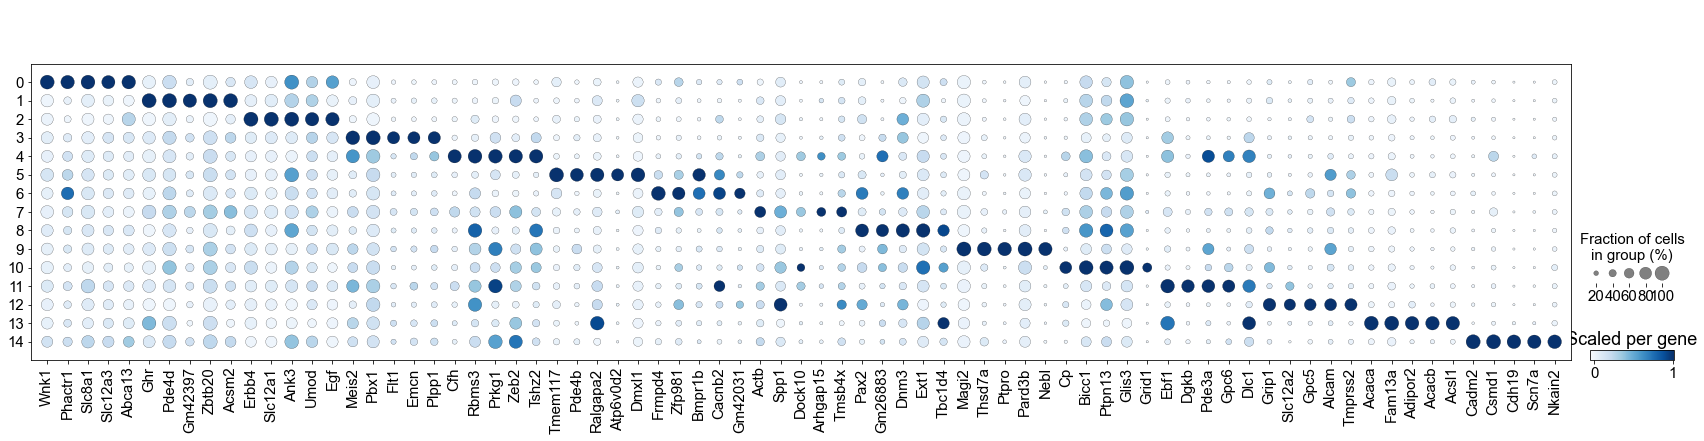

In [40]:
# plot marker genes

n = 5

marker_key = 'rank_genes_groups' + str(res)

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()

unique_markers = []

print("Number of clusters", marker_genes.shape[0])

for k in range(marker_genes.shape[0]):
    i = 0
    tmp_markers = []
    for g in marker_genes[k, :]:
        if g =="nan": continue
        if i < n and g not in unique_markers:
            tmp_markers.append(g)
            i += 1
    print(k, tmp_markers)
    unique_markers.extend(tmp_markers)

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              use_raw=False,
              groupby='leiden'+str(res),
              log=False,
              standard_scale='var',
              color_map='Blues',
              vmin=-0.05,
              vmax=1.01,
              smallest_dot=5,
              show=False)
plt.title('Scaled per gene')
plt.show()